**Basic PLSR, No pre-processing, No outlier detection**

Prepare partinioned files before running this file:

•	Remove extra columns from the partitioned data sets: Remove “Sample ID”, “Mass”, “Major dia”, “Fertilty ”, “Thickness”, “Shell strength”.


•	Rename the “Thickness (mm)” column as “Ref”.


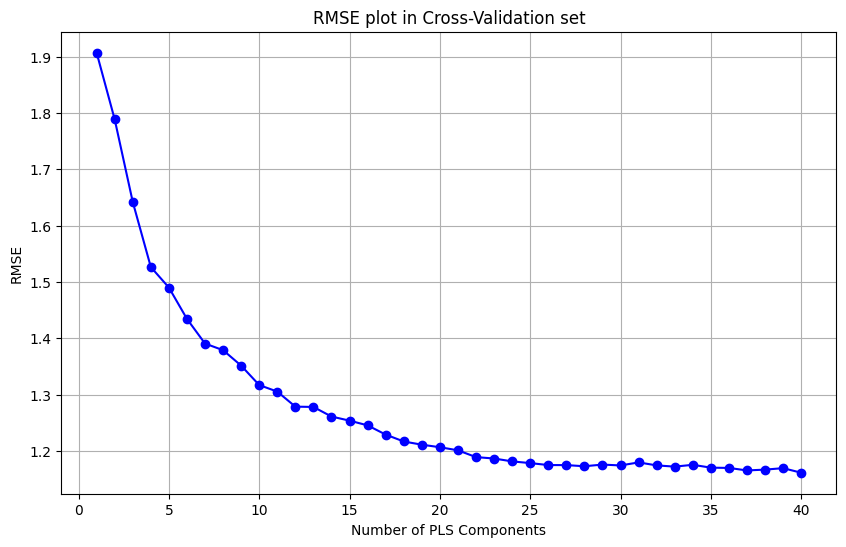

{'Calibration': {'R2': 0.737920490293762, 'RMSE': np.float64(0.996273498280487), 'RPD': np.float64(1.9533652894019735)}, 'Cross-Validation': {'R2': 0.6373113031843594, 'RMSE': np.float64(1.1720038938329362), 'RPD': np.float64(1.6604774783876148)}, 'Validation': {'R2': 0.6703985379291273, 'RMSE': np.float64(0.9897761494917322), 'RPD': np.float64(1.741828672449094)}}


In [1]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the calibration and validation data
calibration_file_path = '/content/Cal_Rand.csv'  # Add your calibration set path
validation_file_path = '/content/Test_Rand.csv'  # Add your validation/Test set path

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal_new_clean = calibration_data.drop(columns=['Ref'])
y_cal_new_clean = calibration_data['Ref']
X_val_new_clean = validation_data.drop(columns=['Ref'])
y_val_new_clean = validation_data['Ref']

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_cal_new_clean_scaled = scaler_X.fit_transform(X_cal_new_clean)
X_val_new_clean_scaled = scaler_X.transform(X_val_new_clean)
y_cal_new_clean_scaled = scaler_y.fit_transform(y_cal_new_clean.values.reshape(-1, 1)).ravel()
y_val_new_clean_scaled = scaler_y.transform(y_val_new_clean.values.reshape(-1, 1)).ravel()

# Function to calculate RMSE for different numbers of PLS components using cross-validation
def calculate_rmse_for_components_cv(X, y, scaler_y, max_components):
    rmse_values = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n)
        y_cv_pred = cross_val_predict(pls, X, y, cv=cv)
        y_cv_pred_inverse = scaler_y.inverse_transform(y_cv_pred.reshape(-1, 1))
        y_inverse = scaler_y.inverse_transform(y.reshape(-1, 1))

        # Updated RMSE calculation
        if hasattr(mean_squared_error, 'squared'):
            rmse = mean_squared_error(y_inverse, y_cv_pred_inverse, squared=False)
        else:
            rmse = np.sqrt(mean_squared_error(y_inverse, y_cv_pred_inverse))

        rmse_values.append(rmse)

    return rmse_values

# Define the maximum number of PLS components to test
max_components = 40 ## (Check the plot and change this value)##############
rmse_values_cv = calculate_rmse_for_components_cv(X_cal_new_clean_scaled, y_cal_new_clean_scaled, scaler_y, max_components)

# Plot RMSE vs Number of PLS components for cross-validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), rmse_values_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('RMSE plot in Cross-Validation set')
plt.grid(True)
plt.show()

## Development of PLSR model
n_components = 33  # Check the LV plot and update this value for your model developemnt###########################

# Initialize and train the PLSR model
pls_new_clean = PLSRegression(n_components=n_components)
pls_new_clean.fit(X_cal_new_clean_scaled, y_cal_new_clean_scaled)

# Perform 10-fold cross-validation
cv_new_clean = KFold(n_splits=10, shuffle=True, random_state=42)
y_cv_new_clean = cross_val_predict(pls_new_clean, X_cal_new_clean_scaled, y_cal_new_clean_scaled, cv=cv_new_clean)

# Predict on the validation set
y_val_pred_new_clean = pls_new_clean.predict(X_val_new_clean_scaled)

# Function to calculate R², RMSE, and RPD
def calculate_metrics(y_true, y_pred, scaler_y):
    y_true_inverse = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y_true_inverse, y_pred_inverse)

    # Updated RMSE calculation
    if hasattr(mean_squared_error, 'squared'):
        rmse = mean_squared_error(y_true_inverse, y_pred_inverse, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))

    rpd = np.std(y_true_inverse) / rmse
    return r2, rmse, rpd

# Metrics for calibration set
r2_cal_new_clean, rmse_cal_new_clean, rpd_cal_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, pls_new_clean.predict(X_cal_new_clean_scaled), scaler_y)

# Metrics for cross-validation
r2_cv_new_clean, rmse_cv_new_clean, rpd_cv_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, y_cv_new_clean, scaler_y)

# Metrics for validation set
r2_val_new_clean, rmse_val_new_clean, rpd_val_new_clean = calculate_metrics(
    y_val_new_clean_scaled, y_val_pred_new_clean, scaler_y)

# Display the results
results_new_clean = {
    'Calibration': {'R2': r2_cal_new_clean, 'RMSE': rmse_cal_new_clean, 'RPD': rpd_cal_new_clean},
    'Cross-Validation': {'R2': r2_cv_new_clean, 'RMSE': rmse_cv_new_clean, 'RPD': rpd_cv_new_clean},
    'Validation': {'R2': r2_val_new_clean, 'RMSE': rmse_val_new_clean, 'RPD': rpd_val_new_clean}
}

print(results_new_clean)

**PLSR+ FD pre-processing but no outliers removal-Chnage the LV numbers using LV plot information**

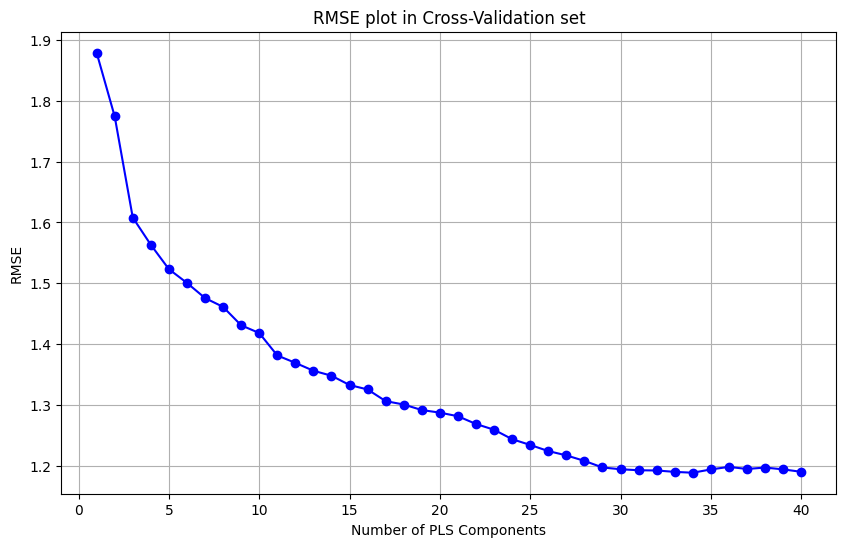

{'Calibration': {'R2': 0.6853542046220796, 'RMSE': np.float64(1.0916238367604776), 'RPD': np.float64(1.7827442061611807)}, 'Cross-Validation': {'R2': 0.6260487713672077, 'RMSE': np.float64(1.190061831153155), 'RPD': np.float64(1.6352814781114748)}, 'Validation': {'R2': 0.6585811812192208, 'RMSE': np.float64(1.2393506546814843), 'RPD': np.float64(1.711418696938871)}}


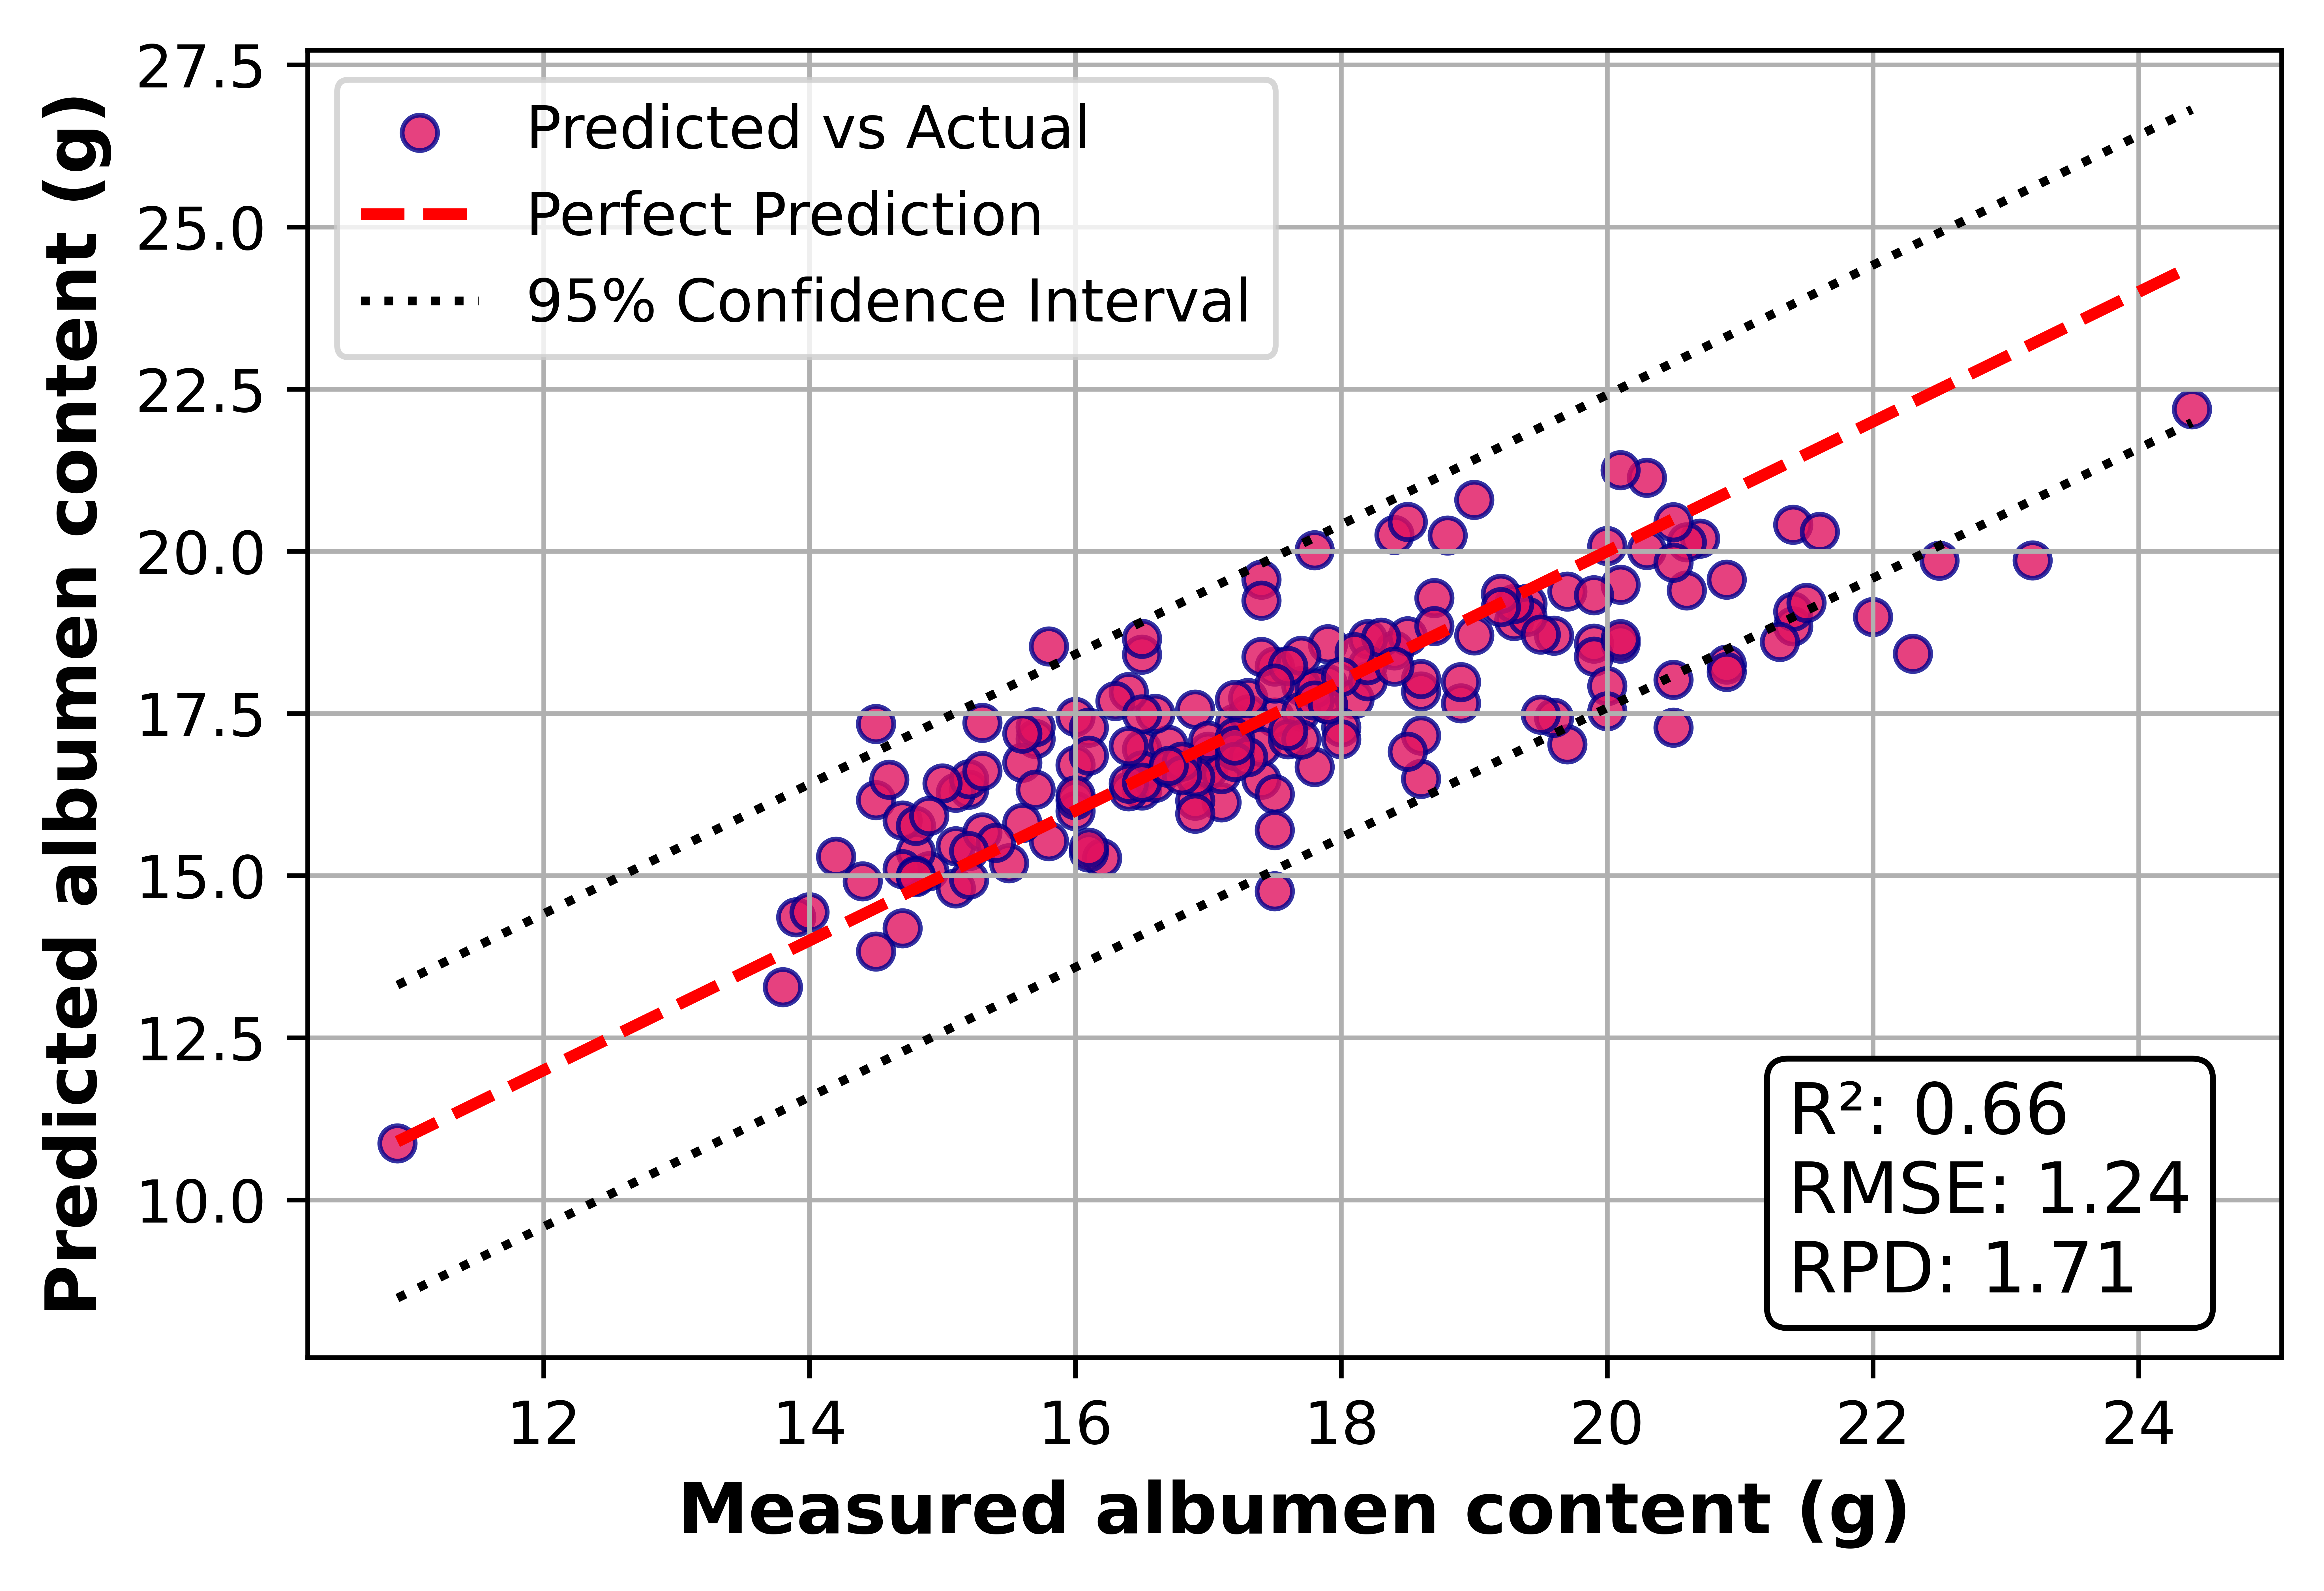

In [4]:
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Load the calibration and validation data
calibration_file_path = '/content/Cal_Rand.csv'  # Add your calibration set path
validation_file_path = '/content/Val_Rand.csv'    # Add your validation set path

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal_new_clean = calibration_data.drop(columns=['Ref'])
y_cal_new_clean = calibration_data['Ref']
X_val_new_clean = validation_data.drop(columns=['Ref'])
y_val_new_clean = validation_data['Ref']

# Apply Savitzky-Golay filter (1st derivative)
X_cal_sg = savgol_filter(X_cal_new_clean, window_length=21, polyorder=2, deriv=1, axis=1)### Change derive and windows length; Ensure window_length < total number of variables
X_val_sg = savgol_filter(X_val_new_clean, window_length=21, polyorder=2, deriv=1, axis=1)### Ensure same deriv in both sets

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_cal_sg_scaled = scaler_X.fit_transform(X_cal_sg)
X_val_sg_scaled = scaler_X.transform(X_val_sg)
y_cal_new_clean_scaled = scaler_y.fit_transform(y_cal_new_clean.values.reshape(-1, 1)).ravel()
y_val_new_clean_scaled = scaler_y.transform(y_val_new_clean.values.reshape(-1, 1)).ravel()

# Function to calculate RMSE for different numbers of PLS components using cross-validation
def calculate_rmse_for_components_cv(X, y, scaler_y, max_components):
    rmse_values = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n)
        y_cv_pred = cross_val_predict(pls, X, y, cv=cv)
        y_cv_pred_inverse = scaler_y.inverse_transform(y_cv_pred.reshape(-1, 1))
        y_inverse = scaler_y.inverse_transform(y.reshape(-1, 1))

        # Updated RMSE calculation
        if hasattr(mean_squared_error, 'squared'):
            rmse = mean_squared_error(y_inverse, y_cv_pred_inverse, squared=False)
        else:
            rmse = np.sqrt(mean_squared_error(y_inverse, y_cv_pred_inverse))

        rmse_values.append(rmse)

    return rmse_values

# Define the maximum number of PLS components to test
max_components = 40  # Ensure this value <= total number of variables
rmse_values_cv = calculate_rmse_for_components_cv(X_cal_sg_scaled, y_cal_new_clean_scaled, scaler_y, max_components)

# Plot RMSE vs Number of PLS components for cross-validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), rmse_values_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('RMSE plot in Cross-Validation set')
plt.grid(True)
plt.show()

## Development of PLSR model
n_components = 33  ############### Adjust based on LV plot(use lowest RMSE)##############################

# Initialize and train the PLSR model
pls_new_clean = PLSRegression(n_components=n_components)
pls_new_clean.fit(X_cal_sg_scaled, y_cal_new_clean_scaled)

# Perform 10-fold cross-validation
cv_new_clean = KFold(n_splits=10, shuffle=True, random_state=42)
y_cv_new_clean = cross_val_predict(pls_new_clean, X_cal_sg_scaled, y_cal_new_clean_scaled, cv=cv_new_clean)

# Predict on the validation set
y_val_pred_new_clean = pls_new_clean.predict(X_val_sg_scaled)

# Function to calculate R², RMSE, and RPD
def calculate_metrics(y_true, y_pred, scaler_y):
    y_true_inverse = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y_true_inverse, y_pred_inverse)

    # Updated RMSE calculation
    if hasattr(mean_squared_error, 'squared'):
        rmse = mean_squared_error(y_true_inverse, y_pred_inverse, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))

    rpd = np.std(y_true_inverse) / rmse
    return r2, rmse, rpd

# Metrics for calibration set
r2_cal_new_clean, rmse_cal_new_clean, rpd_cal_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, pls_new_clean.predict(X_cal_sg_scaled), scaler_y)

# Metrics for cross-validation
r2_cv_new_clean, rmse_cv_new_clean, rpd_cv_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, y_cv_new_clean, scaler_y)

# Metrics for validation set
r2_val_new_clean, rmse_val_new_clean, rpd_val_new_clean = calculate_metrics(
    y_val_new_clean_scaled, y_val_pred_new_clean, scaler_y)

# Display the results
results_new_clean = {
    'Calibration': {'R2': r2_cal_new_clean, 'RMSE': rmse_cal_new_clean, 'RPD': rpd_cal_new_clean},
    'Cross-Validation': {'R2': r2_cv_new_clean, 'RMSE': rmse_cv_new_clean, 'RPD': rpd_cv_new_clean},
    'Validation': {'R2': r2_val_new_clean, 'RMSE': rmse_val_new_clean, 'RPD': rpd_val_new_clean}
}

print(results_new_clean)

# Scatter plot for validation set
y_val_true_inverse = scaler_y.inverse_transform(y_val_new_clean_scaled.reshape(-1, 1))
y_val_pred_inverse = scaler_y.inverse_transform(y_val_pred_new_clean.reshape(-1, 1))

# Calculate residuals
residuals = y_val_true_inverse - y_val_pred_inverse
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence level

upper_ci = y_val_true_inverse + confidence_interval
lower_ci = y_val_true_inverse - confidence_interval
plt.figure(figsize=(6, 4), dpi=1500)
plt.scatter(y_val_true_inverse, y_val_pred_inverse,
            alpha=0.8,
            facecolors='#e0115f',              # Fill color: ruby
            edgecolors='#00008B',              # Edge color: deep blue (navy)
            linewidth=0.8,
            label='Predicted vs Actual')       ### change color of the dots here
#plt.figure(figsize=(6, 4), dpi=1500)
#plt.scatter(y_val_true_inverse, y_val_pred_inverse, alpha=0.7, edgecolors='r', label='Predicted vs Actual') ### change color of the dots here

plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [y_val_true_inverse.min(), y_val_true_inverse.max()], 'r--', lw=2, label='Perfect Prediction')

plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [upper_ci.min(), upper_ci.max()], 'k:', label='95% Confidence Interval')
plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [lower_ci.min(), lower_ci.max()], 'k:')

plt.xlabel('Measured albumen content (g)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted albumen content (g)', fontsize=12, fontweight='bold')

plt.legend(loc='upper left')
plt.text(0.75, 0.05, f'R²: {r2_val_new_clean:.2f}\nRMSE: {rmse_val_new_clean:.2f}\nRPD: {rpd_val_new_clean:.2f}',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.grid(True)
plt.show()

**MSC pre-processing_+PLSR**

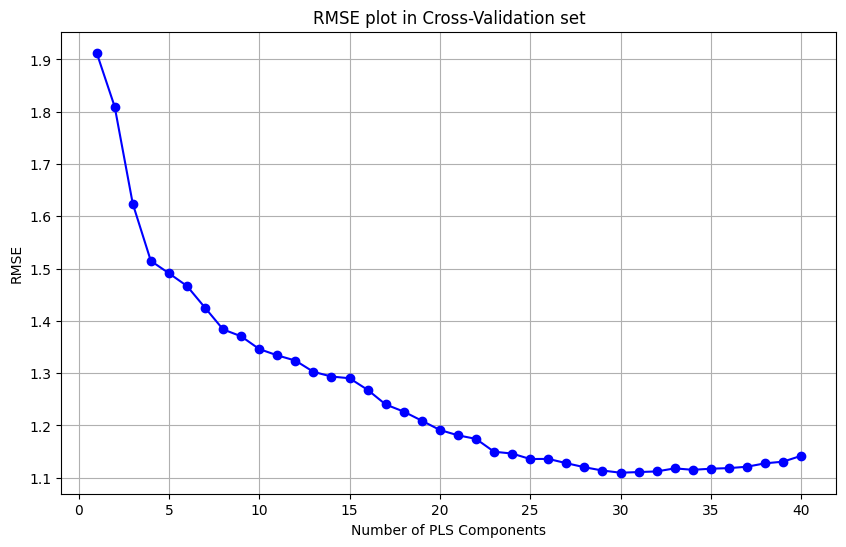

{'Calibration': {'R2': 0.7404437758660265, 'RMSE': np.float64(0.9914658680897168), 'RPD': np.float64(1.9628371817193815)}, 'Cross-Validation': {'R2': 0.6749482620494326, 'RMSE': np.float64(1.1095280606297755), 'RPD': np.float64(1.7539764331760734)}, 'Validation': {'R2': 0.688908312817561, 'RMSE': np.float64(0.9615826592454608), 'RPD': np.float64(1.7928988838502686)}}


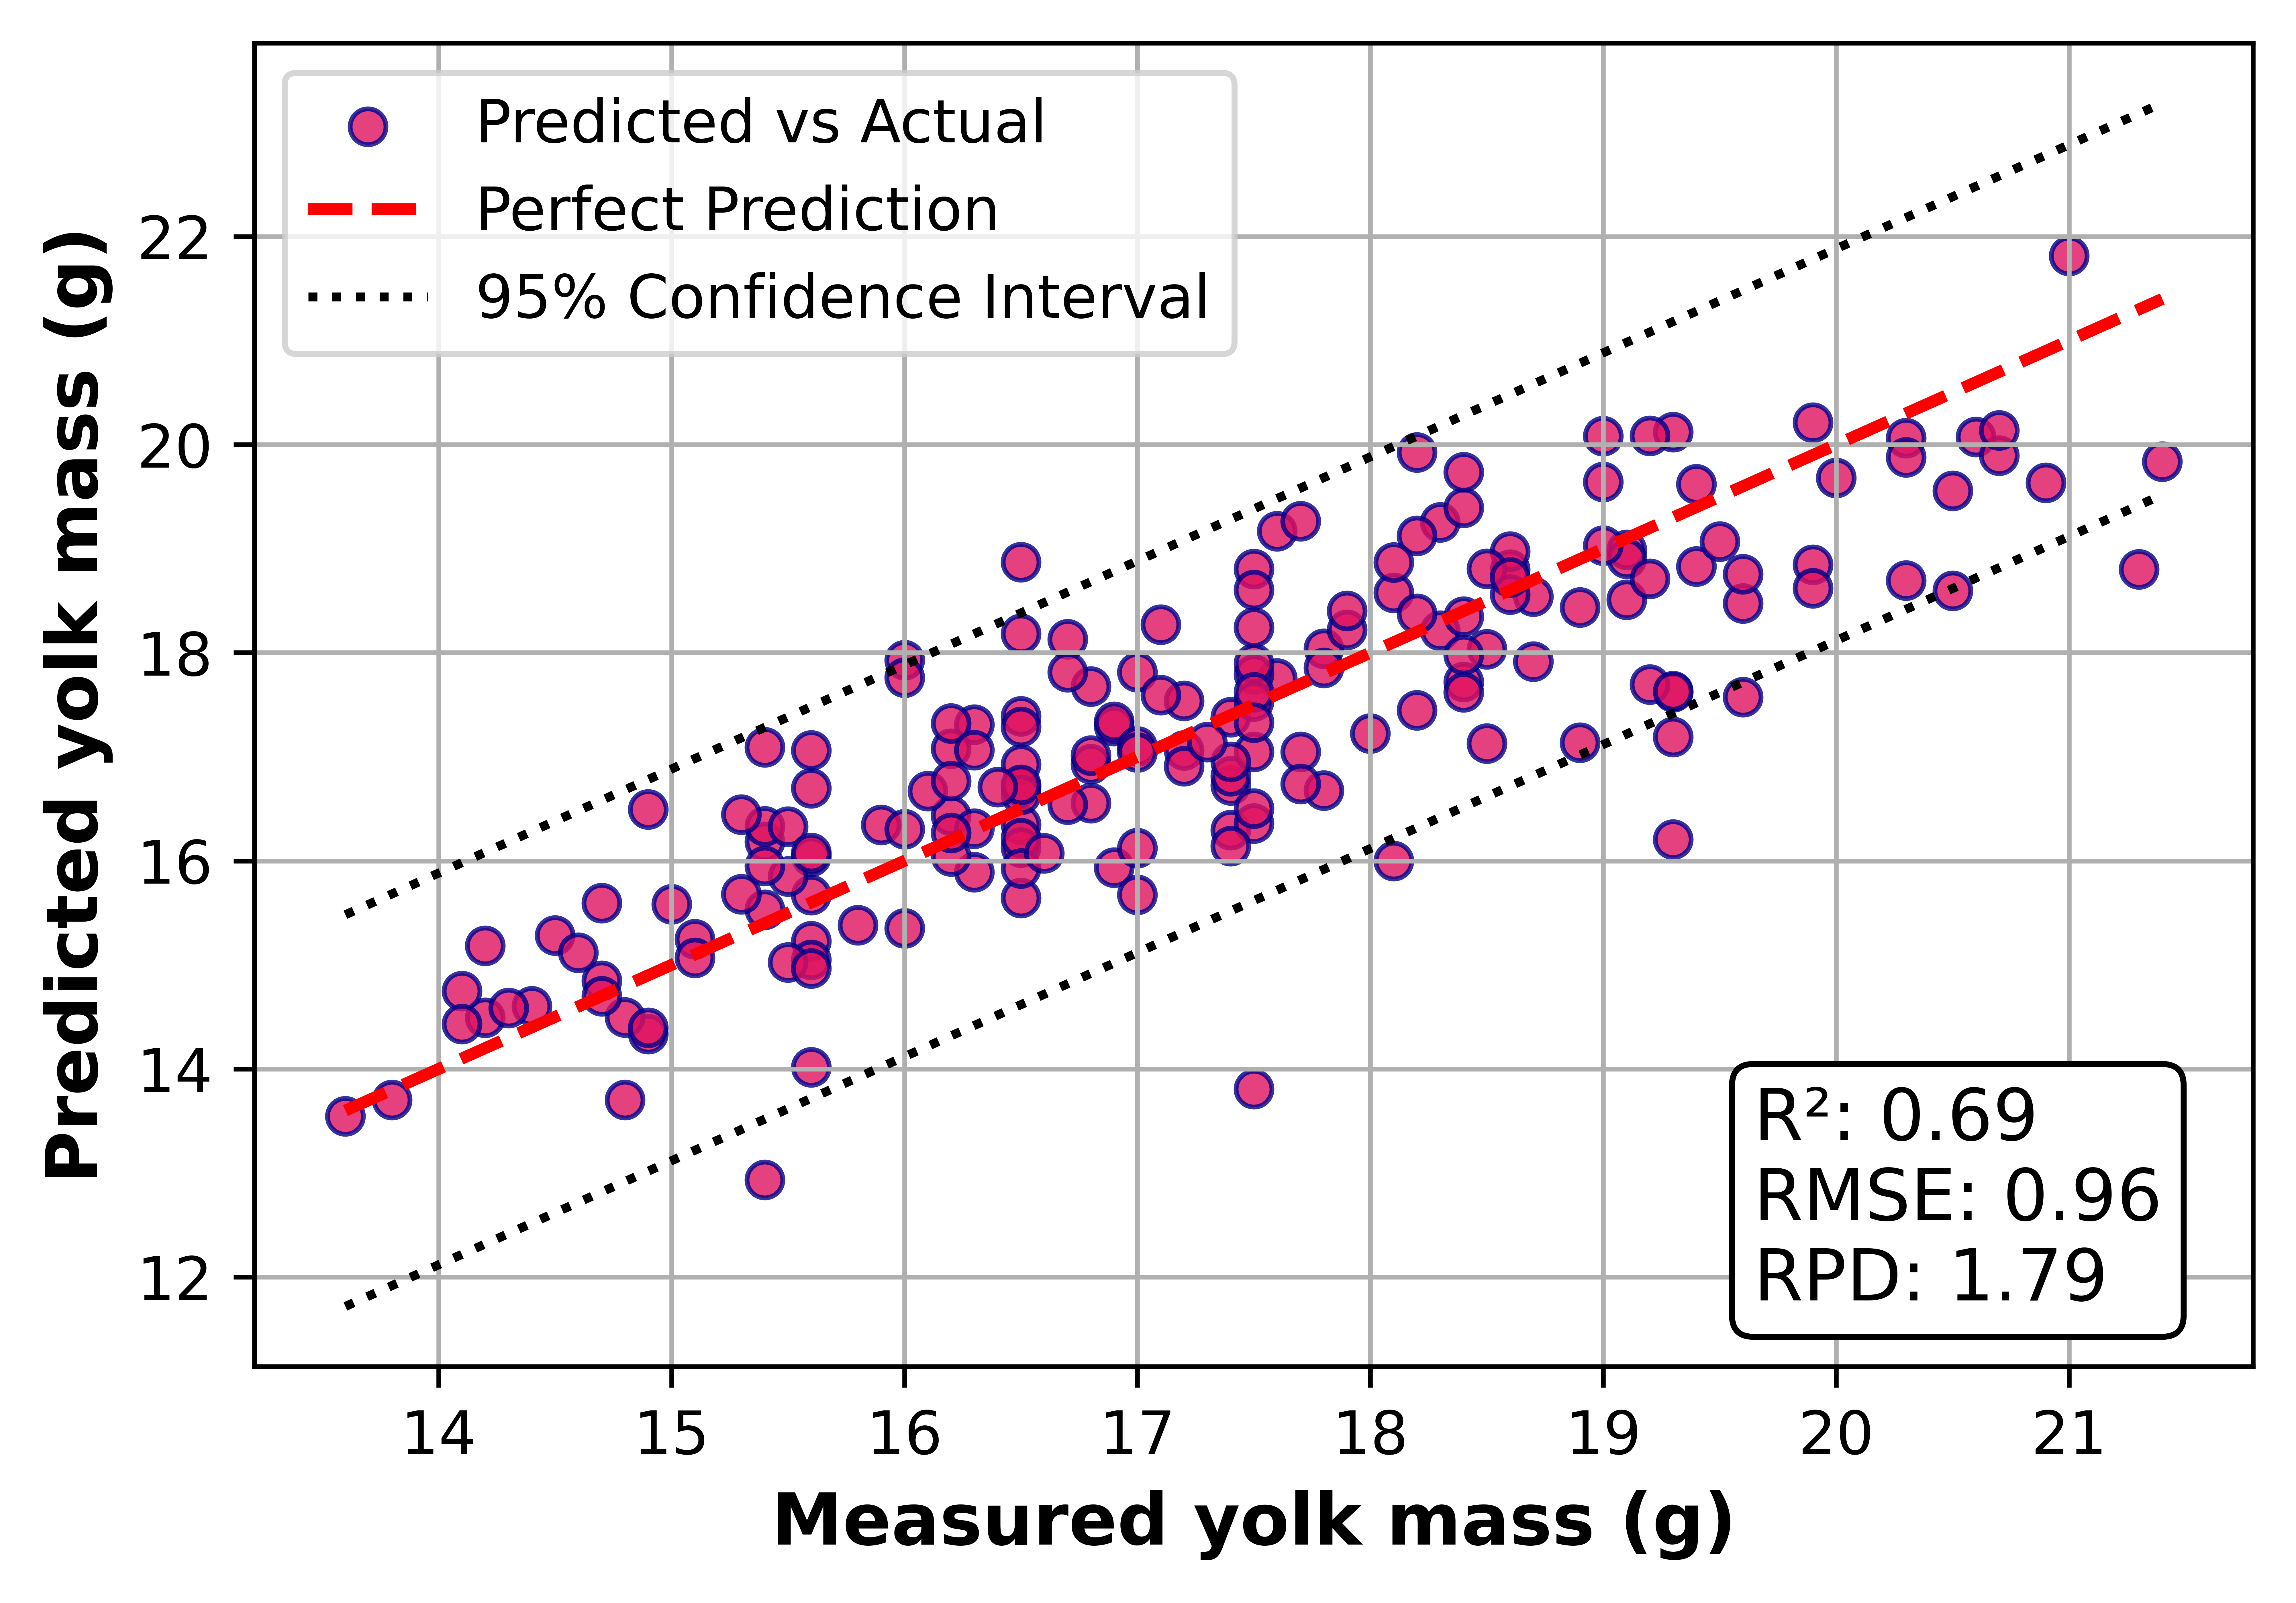

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the calibration and validation data
calibration_file_path = '/content/Cal_Rand.csv'  # Add your calibration set path
validation_file_path = '/content/Test_Rand.csv'    # Add your validation/Test set path

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal_new_clean = calibration_data.drop(columns=['Ref'])
y_cal_new_clean = calibration_data['Ref']
X_val_new_clean = validation_data.drop(columns=['Ref'])
y_val_new_clean = validation_data['Ref']

# Function to apply Multiplicative Scatter Correction (MSC)
def apply_msc(X, X_ref=None):
    """
    Perform Multiplicative Scatter Correction (MSC) on spectral data.
    X: Spectral matrix (samples x variables)
    X_ref: Optional reference spectrum (default: mean spectrum of X)
    """
    X = np.array(X)
    if X_ref is None:
        X_ref = np.mean(X, axis=0)

    X_msc = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(X_ref, X[i, :], 1)
        X_msc[i, :] = (X[i, :] - intercept) / slope
    return X_msc

# Apply MSC to the calibration and validation data
X_cal_msc = apply_msc(X_cal_new_clean)
X_val_msc = apply_msc(X_val_new_clean, X_ref=np.mean(X_cal_msc, axis=0))  # Use calibration mean as reference

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_cal_msc_scaled = scaler_X.fit_transform(X_cal_msc)
X_val_msc_scaled = scaler_X.transform(X_val_msc)
y_cal_new_clean_scaled = scaler_y.fit_transform(y_cal_new_clean.values.reshape(-1, 1)).ravel()
y_val_new_clean_scaled = scaler_y.transform(y_val_new_clean.values.reshape(-1, 1)).ravel()

# Function to calculate RMSE for different numbers of PLS components using cross-validation
def calculate_rmse_for_components_cv(X, y, scaler_y, max_components):
    rmse_values = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n)
        y_cv_pred = cross_val_predict(pls, X, y, cv=cv)
        y_cv_pred_inverse = scaler_y.inverse_transform(y_cv_pred.reshape(-1, 1))
        y_inverse = scaler_y.inverse_transform(y.reshape(-1, 1))

        # Updated RMSE calculation
        if hasattr(mean_squared_error, 'squared'):
            rmse = mean_squared_error(y_inverse, y_cv_pred_inverse, squared=False)
        else:
            rmse = np.sqrt(mean_squared_error(y_inverse, y_cv_pred_inverse))

        rmse_values.append(rmse)

    return rmse_values

# Define the maximum number of PLS components to test
max_components = 40  # Ensure this value <= total number of variables
rmse_values_cv = calculate_rmse_for_components_cv(X_cal_msc_scaled, y_cal_new_clean_scaled, scaler_y, max_components)

# Plot RMSE vs Number of PLS components for cross-validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), rmse_values_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('RMSE plot in Cross-Validation set')
plt.grid(True)
plt.show()

## Development of PLSR model
n_components = 30 # Adjust based on LV plot(use lowest RMSE)

# Initialize and train the PLSR model
pls_new_clean = PLSRegression(n_components=n_components)
pls_new_clean.fit(X_cal_msc_scaled, y_cal_new_clean_scaled)

# Perform 10-fold cross-validation
cv_new_clean = KFold(n_splits=10, shuffle=True, random_state=42)
y_cv_new_clean = cross_val_predict(pls_new_clean, X_cal_msc_scaled, y_cal_new_clean_scaled, cv=cv_new_clean)

# Predict on the validation set
y_val_pred_new_clean = pls_new_clean.predict(X_val_msc_scaled)

# Function to calculate R², RMSE, and RPD
def calculate_metrics(y_true, y_pred, scaler_y):
    y_true_inverse = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y_true_inverse, y_pred_inverse)

    # Updated RMSE calculation
    if hasattr(mean_squared_error, 'squared'):
        rmse = mean_squared_error(y_true_inverse, y_pred_inverse, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))

    rpd = np.std(y_true_inverse) / rmse
    return r2, rmse, rpd

# Metrics for calibration set
r2_cal_new_clean, rmse_cal_new_clean, rpd_cal_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, pls_new_clean.predict(X_cal_msc_scaled), scaler_y)

# Metrics for cross-validation
r2_cv_new_clean, rmse_cv_new_clean, rpd_cv_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, y_cv_new_clean, scaler_y)

# Metrics for validation set
r2_val_new_clean, rmse_val_new_clean, rpd_val_new_clean = calculate_metrics(
    y_val_new_clean_scaled, y_val_pred_new_clean, scaler_y)

# Display the results
results_new_clean = {
    'Calibration': {'R2': r2_cal_new_clean, 'RMSE': rmse_cal_new_clean, 'RPD': rpd_cal_new_clean},
    'Cross-Validation': {'R2': r2_cv_new_clean, 'RMSE': rmse_cv_new_clean, 'RPD': rpd_cv_new_clean},
    'Validation': {'R2': r2_val_new_clean, 'RMSE': rmse_val_new_clean, 'RPD': rpd_val_new_clean}
}

print(results_new_clean)

# # Scatter plot for validation set
y_val_true_inverse = scaler_y.inverse_transform(y_val_new_clean_scaled.reshape(-1, 1))
y_val_pred_inverse = scaler_y.inverse_transform(y_val_pred_new_clean.reshape(-1, 1))

# Calculate residuals
residuals = y_val_true_inverse - y_val_pred_inverse
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence level

upper_ci = y_val_true_inverse + confidence_interval
lower_ci = y_val_true_inverse - confidence_interval
plt.figure(figsize=(6, 4), dpi=1500)
plt.scatter(y_val_true_inverse, y_val_pred_inverse,
            alpha=0.8,
            facecolors='#e0115f',              # Fill color: Val1=#06B48B, green ; Test=#e0115f,ruby
            edgecolors='#00008B',              # Edge color: deep blue (navy)
            linewidth=0.8,
            label='Predicted vs Actual')       ### change color of the dots here
#plt.figure(figsize=(6, 4), dpi=1500)
#plt.scatter(y_val_true_inverse, y_val_pred_inverse, alpha=0.7, edgecolors='r', label='Predicted vs Actual') ### change color of the dots here

plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [y_val_true_inverse.min(), y_val_true_inverse.max()], 'r--', lw=2, label='Perfect Prediction')

plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [upper_ci.min(), upper_ci.max()], 'k:', label='95% Confidence Interval')
plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [lower_ci.min(), lower_ci.max()], 'k:')

plt.xlabel('Measured yolk mass (g)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted yolk mass (g)', fontsize=12, fontweight='bold')

plt.legend(loc='upper left')
plt.text(0.75, 0.05, f'R²: {r2_val_new_clean:.2f}\nRMSE: {rmse_val_new_clean:.2f}\nRPD: {rpd_val_new_clean:.2f}',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.grid(True)
plt.show()

**SNV-PLSR**

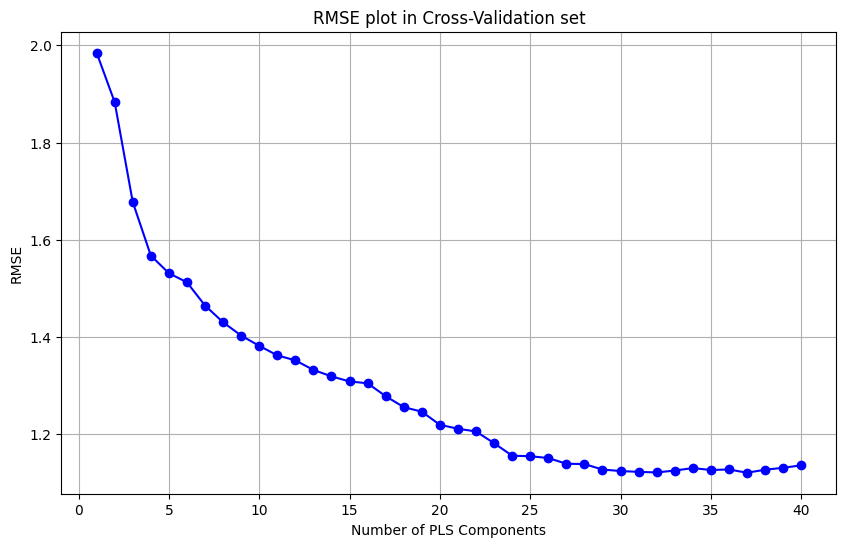

{'Calibration': {'R2': 0.7594520729914311, 'RMSE': np.float64(0.9934940113193483), 'RPD': np.float64(2.0389153275980445)}, 'Cross-Validation': {'R2': 0.6926758894492661, 'RMSE': np.float64(1.1229560543538943), 'RPD': np.float64(1.803855244114041)}, 'Validation': {'R2': 0.6371225103953493, 'RMSE': np.float64(1.0208567603069965), 'RPD': np.float64(1.6600454772744735)}}


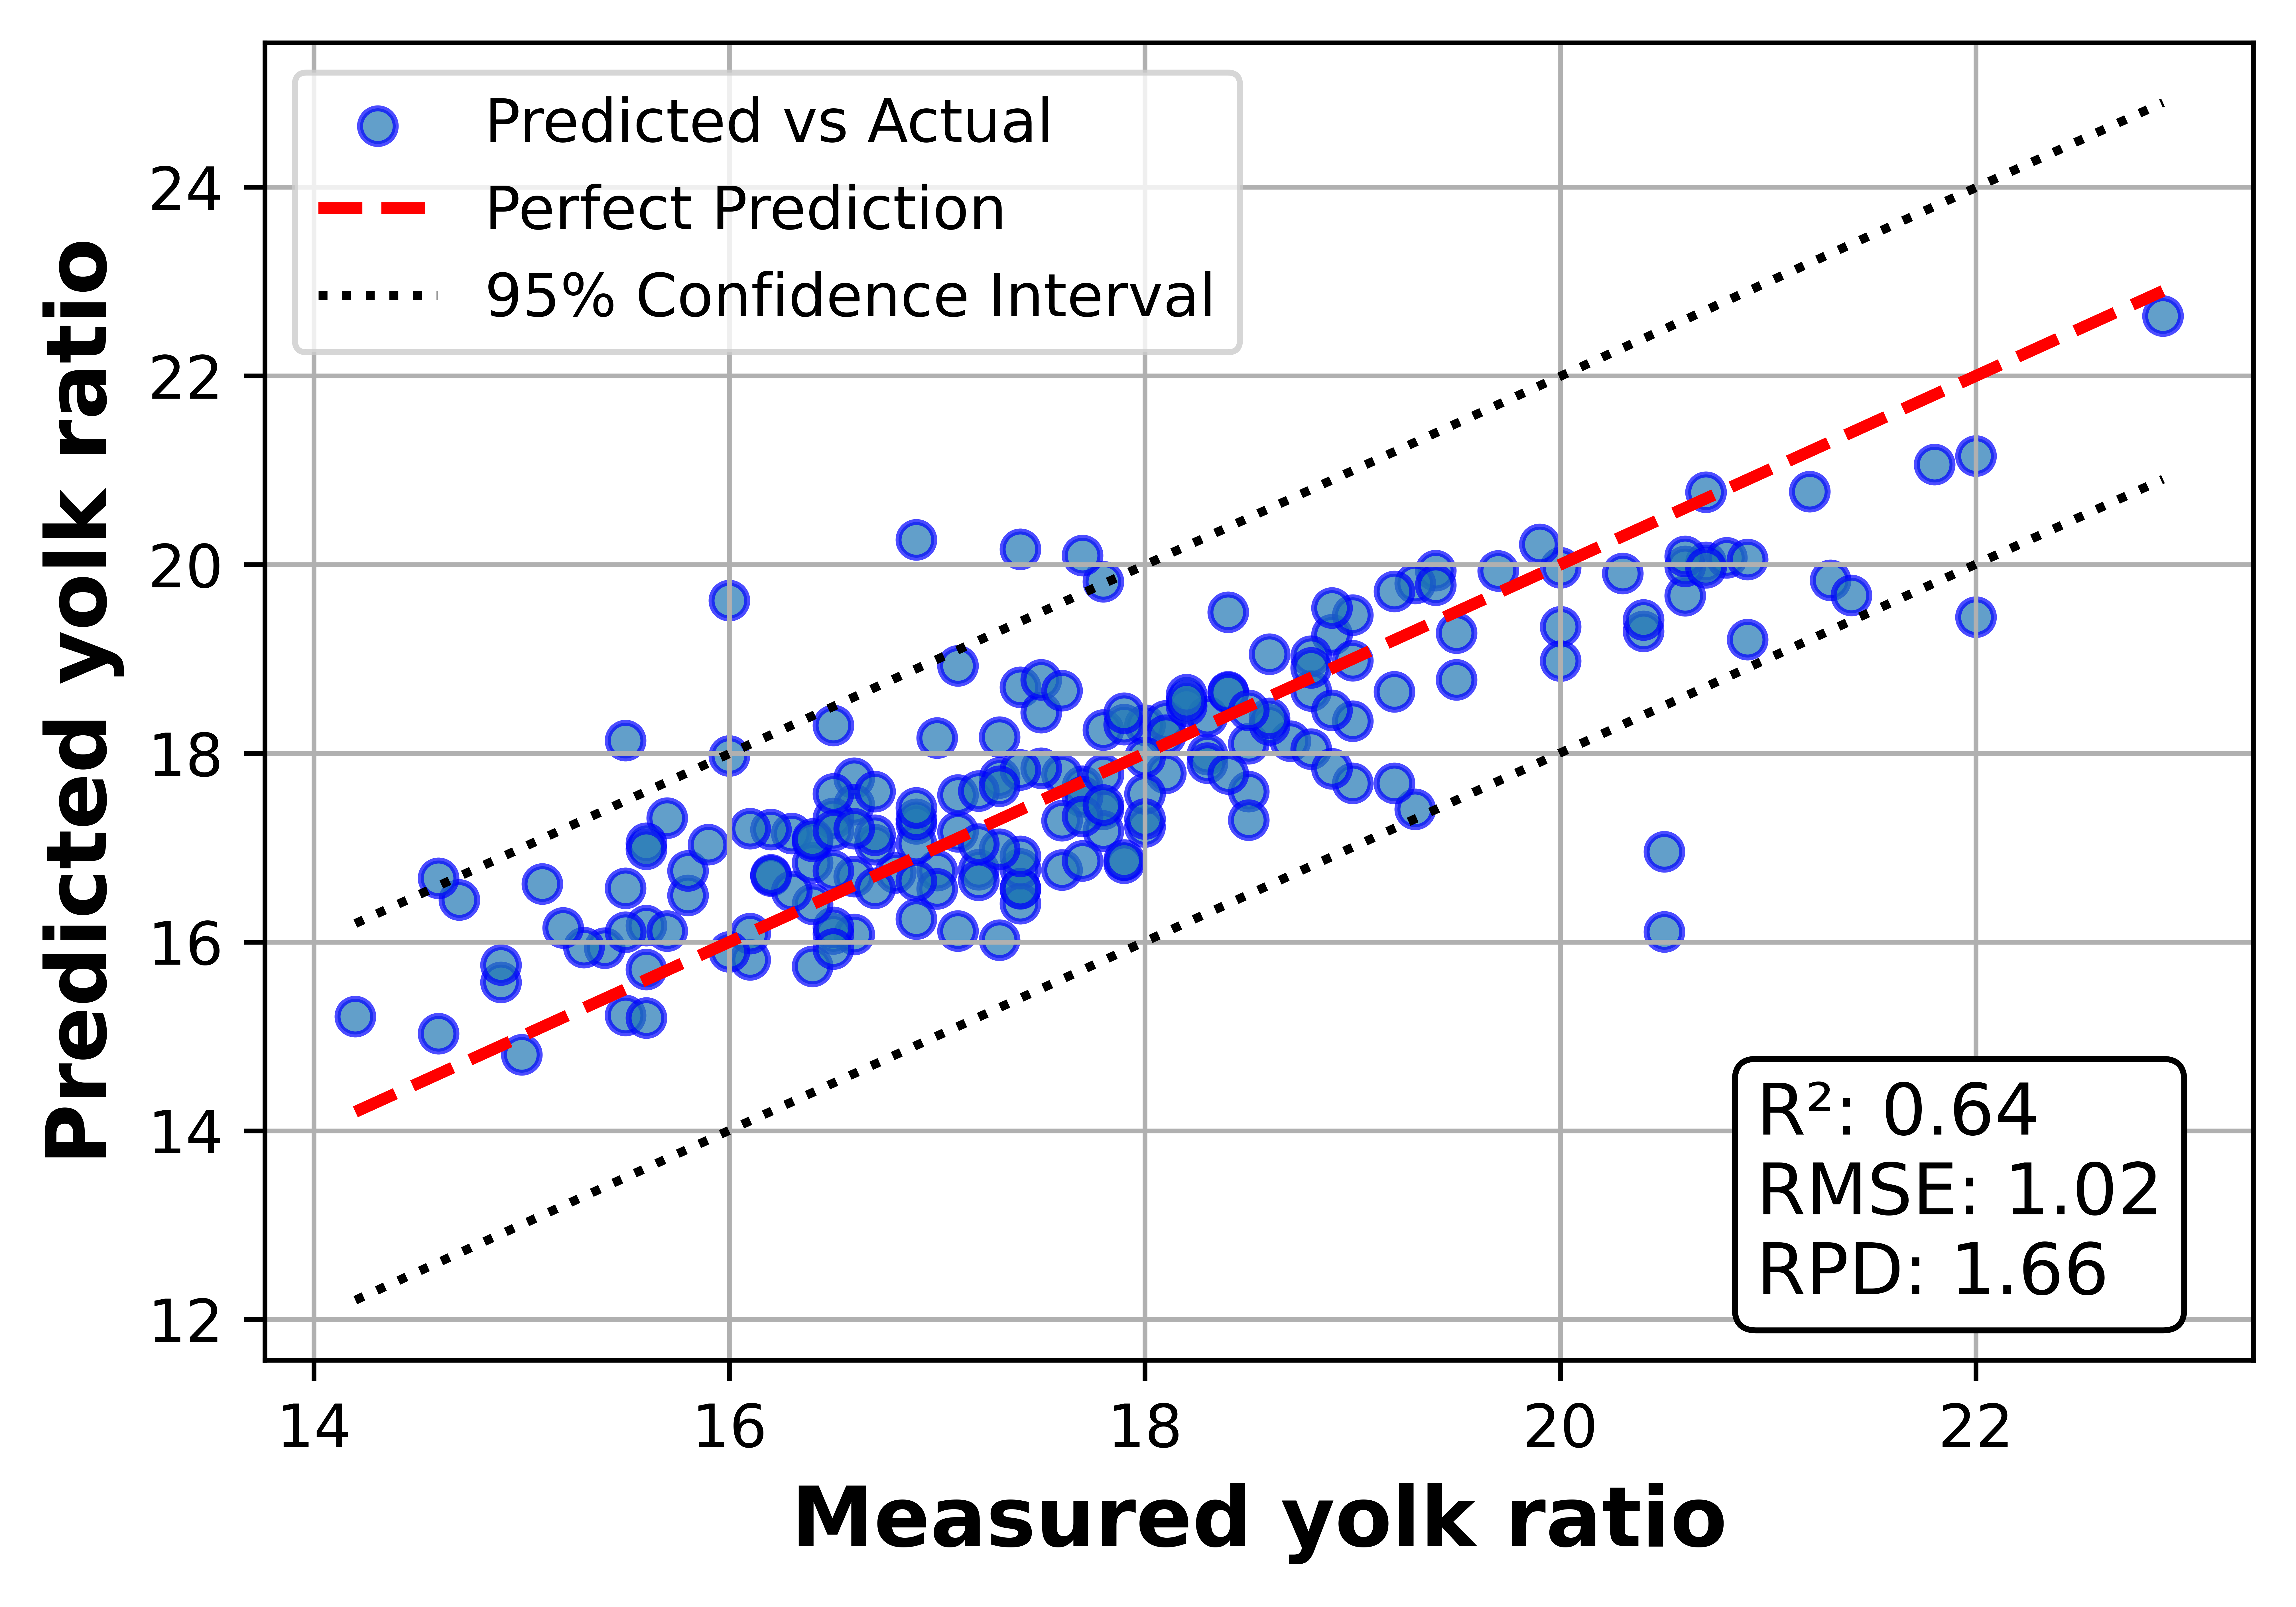

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the calibration and validation data
calibration_file_path = '/content/Calibration_KS.csv'  # Add your calibration set path
validation_file_path = '/content/Validation2_KS.csv'    # Add your validation set path

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal_new_clean = calibration_data.drop(columns=['Ref'])
y_cal_new_clean = calibration_data['Ref']
X_val_new_clean = validation_data.drop(columns=['Ref'])
y_val_new_clean = validation_data['Ref']

# Function to apply Standard Normal Variate (SNV) correction
def apply_snv(X):
    """
    Perform Standard Normal Variate (SNV) on spectral data.
    X: Spectral matrix (samples x variables)
    """
    X = np.array(X)
    X_snv = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)
    return X_snv

# Apply SNV to the calibration and validation data
X_cal_snv = apply_snv(X_cal_new_clean)
X_val_snv = apply_snv(X_val_new_clean)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_cal_snv_scaled = scaler_X.fit_transform(X_cal_snv)
X_val_snv_scaled = scaler_X.transform(X_val_snv)
y_cal_new_clean_scaled = scaler_y.fit_transform(y_cal_new_clean.values.reshape(-1, 1)).ravel()
y_val_new_clean_scaled = scaler_y.transform(y_val_new_clean.values.reshape(-1, 1)).ravel()

# Function to calculate RMSE for different numbers of PLS components using cross-validation
def calculate_rmse_for_components_cv(X, y, scaler_y, max_components):
    rmse_values = []
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n)
        y_cv_pred = cross_val_predict(pls, X, y, cv=cv)
        y_cv_pred_inverse = scaler_y.inverse_transform(y_cv_pred.reshape(-1, 1))
        y_inverse = scaler_y.inverse_transform(y.reshape(-1, 1))

        # Updated RMSE calculation
        if hasattr(mean_squared_error, 'squared'):
            rmse = mean_squared_error(y_inverse, y_cv_pred_inverse, squared=False)
        else:
            rmse = np.sqrt(mean_squared_error(y_inverse, y_cv_pred_inverse))

        rmse_values.append(rmse)

    return rmse_values

# Define the maximum number of PLS components to test
max_components = 40  # Ensure this value <= total number of variables
rmse_values_cv = calculate_rmse_for_components_cv(X_cal_snv_scaled, y_cal_new_clean_scaled, scaler_y, max_components)

# Plot RMSE vs Number of PLS components for cross-validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), rmse_values_cv, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('RMSE plot in Cross-Validation set')
plt.grid(True)
plt.show()

## Development of PLSR model
n_components = 31  # Adjust based on LV plot (use lowest RMSE)

# Initialize and train the PLSR model
pls_new_clean = PLSRegression(n_components=n_components)
pls_new_clean.fit(X_cal_snv_scaled, y_cal_new_clean_scaled)

# Perform 10-fold cross-validation
cv_new_clean = KFold(n_splits=10, shuffle=True, random_state=42)
y_cv_new_clean = cross_val_predict(pls_new_clean, X_cal_snv_scaled, y_cal_new_clean_scaled, cv=cv_new_clean)

# Predict on the validation set
y_val_pred_new_clean = pls_new_clean.predict(X_val_snv_scaled)

# Function to calculate R², RMSE, and RPD
def calculate_metrics(y_true, y_pred, scaler_y):
    y_true_inverse = scaler_y.inverse_transform(y_true.reshape(-1, 1))
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y_true_inverse, y_pred_inverse)

    # Updated RMSE calculation
    if hasattr(mean_squared_error, 'squared'):
        rmse = mean_squared_error(y_true_inverse, y_pred_inverse, squared=False)
    else:
        rmse = np.sqrt(mean_squared_error(y_true_inverse, y_pred_inverse))

    rpd = np.std(y_true_inverse) / rmse
    return r2, rmse, rpd

# Metrics for calibration set
r2_cal_new_clean, rmse_cal_new_clean, rpd_cal_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, pls_new_clean.predict(X_cal_snv_scaled), scaler_y)

# Metrics for cross-validation
r2_cv_new_clean, rmse_cv_new_clean, rpd_cv_new_clean = calculate_metrics(
    y_cal_new_clean_scaled, y_cv_new_clean, scaler_y)

# Metrics for validation set
r2_val_new_clean, rmse_val_new_clean, rpd_val_new_clean = calculate_metrics(
    y_val_new_clean_scaled, y_val_pred_new_clean, scaler_y)

# Display the results
results_new_clean = {
    'Calibration': {'R2': r2_cal_new_clean, 'RMSE': rmse_cal_new_clean, 'RPD': rpd_cal_new_clean},
    'Cross-Validation': {'R2': r2_cv_new_clean, 'RMSE': rmse_cv_new_clean, 'RPD': rpd_cv_new_clean},
    'Validation': {'R2': r2_val_new_clean, 'RMSE': rmse_val_new_clean, 'RPD': rpd_val_new_clean}
}

print(results_new_clean)

# Scatter plot for validation set
y_val_true_inverse = scaler_y.inverse_transform(y_val_new_clean_scaled.reshape(-1, 1))
y_val_pred_inverse = scaler_y.inverse_transform(y_val_pred_new_clean.reshape(-1, 1))

# Calculate residuals
residuals = y_val_true_inverse - y_val_pred_inverse
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence level

upper_ci = y_val_true_inverse + confidence_interval
lower_ci = y_val_true_inverse - confidence_interval

plt.figure(figsize=(6, 4), dpi=1500)
plt.scatter(y_val_true_inverse, y_val_pred_inverse, alpha=0.7, edgecolors='b', label='Predicted vs Actual')
plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [y_val_true_inverse.min(), y_val_true_inverse.max()], 'r--', lw=2, label='Perfect Prediction')

plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [upper_ci.min(), upper_ci.max()], 'k:', label='95% Confidence Interval')
plt.plot([y_val_true_inverse.min(), y_val_true_inverse.max()],
         [lower_ci.min(), lower_ci.max()], 'k:')

plt.xlabel('Measured yolk ratio', fontsize=14, fontweight='bold')
plt.ylabel('Predicted yolk ratio', fontsize=14, fontweight='bold')

plt.legend(loc='upper left')
plt.text(0.75, 0.05, f'R²: {r2_val_new_clean:.2f}\nRMSE: {rmse_val_new_clean:.2f}\nRPD: {rpd_val_new_clean:.2f}',
         transform=plt.gca().transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.grid(True)
plt.show()